In [128]:
#Importing all the libraries
import re
import nltk
import numpy as np
import random
import gensim.downloader as api
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from collections import Counter

In [129]:
#Reading the csv file
df = pd.read_csv('amazon_reviews.csv')
print('The total number of reviews given are: ',len(df))
print(df.describe())
df.head()

The total number of reviews given are:  4915
           overall
count  4915.000000
mean      4.587589
std       0.996845
min       1.000000
25%       5.000000
50%       5.000000
75%       5.000000
max       5.000000


,overall,reviewText
0,4,No issues.
1,5,"Purchased this for my device, it worked as adv..."
2,4,it works as expected. I should have sprung for...
3,5,This think has worked out great.Had a diff. br...
4,5,"Bought it with Retail Packaging, arrived legit..."


**1. DATA PREPARATION:**

1.1.DATA PRE-PROCESSING

In [130]:
#coverting to lowercase
df['reviewText'] = df['reviewText'].str.lower()

In [131]:
#remove all the stopwords and punctuations
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_review(review):
    if not isinstance(review, str):
        return ''
    words = review.split()
    cleaned_words = [re.sub(r'[^a-zA-Z]', '', word) for word in words]
    cleaned_words = [word for word in cleaned_words if word.lower() not in stop_words]
    return ' '.join(cleaned_words)

df['cleanedReviews'] = df['reviewText'].apply(clean_review)

df['cleanedReviews'].head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,cleanedReviews
0,issues
1,purchased device worked advertised never much ...
2,works expected sprung higher capacity think ma...
3,think worked greathad diff bran gb card went s...
4,bought retail packaging arrived legit orange e...


In [132]:
#Vectorizing the reviewText column
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['cleanedReviews'])
y = df['overall']

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [133]:
#Tokenize the reviewText column
nltk.download('punkt')
df['tokenizedReviews'] = df['cleanedReviews'].apply(lambda x: word_tokenize(x))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [134]:
#Remove the stopwords from the tokenized set
df['tokenizedReviews'] = df['tokenizedReviews'].apply(lambda x: [word for word in x if word not in stop_words])

In [135]:
#Display the cleaned and tokenized data
print(f"Feature matrix shape (X): {X.shape}")
print(f"Labels shape (y): {y.shape}")

print(df[['tokenizedReviews', 'overall']].head())

Feature matrix shape (X): (4915, 9679)
Labels shape (y): (4915,)
                                    tokenizedReviews  overall
0                                           [issues]        4
1  [purchased, device, worked, advertised, never,...        5
2  [works, expected, sprung, higher, capacity, th...        4
3  [think, worked, greathad, diff, bran, gb, card...        5
4  [bought, retail, packaging, arrived, legit, or...        5


In [136]:
#Creating the corpus
all_words = [word for sentence in df['tokenizedReviews'] for word in sentence]
word_freq = Counter(all_words)
vocab = {word: idx for idx, (word, _) in enumerate(word_freq.items())}

vocab_size = len(vocab)

print(f"Vocabulary Size: {vocab_size}")
print("Vocabulary:")
print(vocab)

Vocabulary Size: 9696
Vocabulary:
{'issues': 0, 'purchased': 1, 'device': 2, 'worked': 3, 'advertised': 4, 'never': 5, 'much': 6, 'phone': 7, 'memory': 8, 'since': 9, 'download': 10, 'lot': 11, 'stuff': 12, 'brainer': 13, 'works': 14, 'expected': 15, 'sprung': 16, 'higher': 17, 'capacity': 18, 'think': 19, 'made': 20, 'bit': 21, 'cheesier': 22, 'earlier': 23, 'versions': 24, 'paint': 25, 'looks': 26, 'clean': 27, 'greathad': 28, 'diff': 29, 'bran': 30, 'gb': 31, 'card': 32, 'went': 33, 'south': 34, 'monthsthis': 35, 'one': 36, 'held': 37, 'pretty': 38, 'well': 39, 'note': 40, 'update': 41, 'ive': 42, 'months': 43, 'zero': 44, 'transferred': 45, 'reliable': 46, 'solidcheers': 47, 'bought': 48, 'retail': 49, 'packaging': 50, 'arrived': 51, 'legit': 52, 'orange': 53, 'envelope': 54, 'english': 55, 'version': 56, 'asian': 57, 'like': 58, 'picture': 59, 'shows': 60, 'quickly': 61, 'htc': 62, 'sv': 63, 'lg': 64, 'optimus': 65, 'cards': 66, 'working': 67, 'order': 68, 'probably': 69, 'best': 

In [137]:
#Defining the classes (Positive and Negative)
def binary_label(label):
    if label in [1, 2]:
        return 0  # Negative
    elif label in [4, 5]:
        return 1  # Positive
    elif label == 3:
        return random.choice([0, 1]) #Choose randomly for rating 3

In [138]:
#Binary labelling
df['binary_label'] = df['overall'].apply(binary_label)
print(df['binary_label'].value_counts())

binary_label
1    4515
0     400
Name: count, dtype: int64


1.2. DATA SPLITING

In [139]:
# Data Splitting
X = df['cleanedReviews']
y = df['binary_label']

X_train, X_temp, y_train, y_temp = train_test_split(df['cleanedReviews'], df['binary_label'], test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Vectorizing the training, validation, and testing data
vectorizer = TfidfVectorizer()

X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)
X_test_tfidf = vectorizer.transform(X_test)

# Create DataFrames for the train, validation, and test sets
train_df = pd.DataFrame(X_train_tfidf.toarray(), columns=vectorizer.get_feature_names_out())
train_df['binary_label'] = y_train.reset_index(drop=True)
train_df['cleanedReviews'] = X_train.reset_index(drop=True)

val_df = pd.DataFrame(X_val_tfidf.toarray(), columns=vectorizer.get_feature_names_out())
val_df['binary_label'] = y_val.reset_index(drop=True)
val_df['cleanedReviews'] = X_val.reset_index(drop=True)

test_df = pd.DataFrame(X_test_tfidf.toarray(), columns=vectorizer.get_feature_names_out())
test_df['binary_label'] = y_test.reset_index(drop=True)
test_df['cleanedReviews'] = X_test.reset_index(drop=True)

print(f"Training set size: {train_df.shape[0]} samples")
print(f"Validation set size: {val_df.shape[0]} samples")
print(f"Testing set size: {test_df.shape[0]} samples")

Training set size: 3932 samples
Validation set size: 491 samples
Testing set size: 492 samples


1.3. DATA STATISTICS

In [140]:
#Calculating the statistics
def calculate_statistics(df, label_col='binary_label', review_col='reviews'):
    df['token_length'] = df[review_col].apply(lambda x: len(x.split()))

    stats = {
        'num_samples': df.shape[0],
        'min_tokens': df['token_length'].min(),
        'avg_tokens': df['token_length'].mean(),
        'max_tokens': df['token_length'].max(),
        'positive_reviews': (df[label_col] == 1).sum(),
        'negative_reviews': (df[label_col] == 0).sum()
    }

    return stats


In [141]:
# 1. Number of samples in training, validation, and testing datasets
num_train_samples = train_df.shape[0]
num_val_samples = val_df.shape[0]
num_test_samples = test_df.shape[0]

In [142]:
#Tokenization for calculating minimum, average, and maximum tokens
train_df['num_tokens'] = train_df['cleanedReviews'].apply(lambda x: len(x.split()))
val_df['num_tokens'] = val_df['cleanedReviews'].apply(lambda x: len(x.split()))
test_df['num_tokens'] = test_df['cleanedReviews'].apply(lambda x: len(x.split()))

In [143]:
# Calculating min, max, and average number of tokens
train_min_tokens = train_df['num_tokens'].min()
train_max_tokens = train_df['num_tokens'].max()
train_avg_tokens = train_df['num_tokens'].mean()

val_min_tokens = val_df['num_tokens'].min()
val_max_tokens = val_df['num_tokens'].max()
val_avg_tokens = val_df['num_tokens'].mean()

test_min_tokens = test_df['num_tokens'].min()
test_max_tokens = test_df['num_tokens'].max()
test_avg_tokens = test_df['num_tokens'].mean()

In [144]:
# 2. Count of positive and negative reviews
train_positive_count = train_df['binary_label'].value_counts().get(1, 0)
train_negative_count = train_df['binary_label'].value_counts().get(0, 0)

val_positive_count = val_df['binary_label'].value_counts().get(1, 0)
val_negative_count = val_df['binary_label'].value_counts().get(0, 0)

test_positive_count = test_df['binary_label'].value_counts().get(1, 0)
test_negative_count = test_df['binary_label'].value_counts().get(0, 0)


In [145]:
# 3. Create a summary table
summary_data = {
    'Dataset': ['Training', 'Validation', 'Testing'],
    'Number of Samples': [num_train_samples, num_val_samples, num_test_samples],
    'Min Tokens': [train_min_tokens, val_min_tokens, test_min_tokens],
    'Avg Tokens': [train_avg_tokens, val_avg_tokens, test_avg_tokens],
    'Max Tokens': [train_max_tokens, val_max_tokens, test_max_tokens],
    'Positive Reviews': [train_positive_count, val_positive_count, test_positive_count],
    'Negative Reviews': [train_negative_count, val_negative_count, test_negative_count]
}

In [146]:
summary_df = pd.DataFrame(summary_data)
print(summary_df)

      Dataset  Number of Samples  Min Tokens  Avg Tokens  Max Tokens  \
0    Training               3932           0   25.357070         781   
1  Validation                491           1   24.183299         544   
2     Testing                492           1   26.796748         420   

   Positive Reviews  Negative Reviews  
0              3614               318  
1               450                41  
2               451                41  


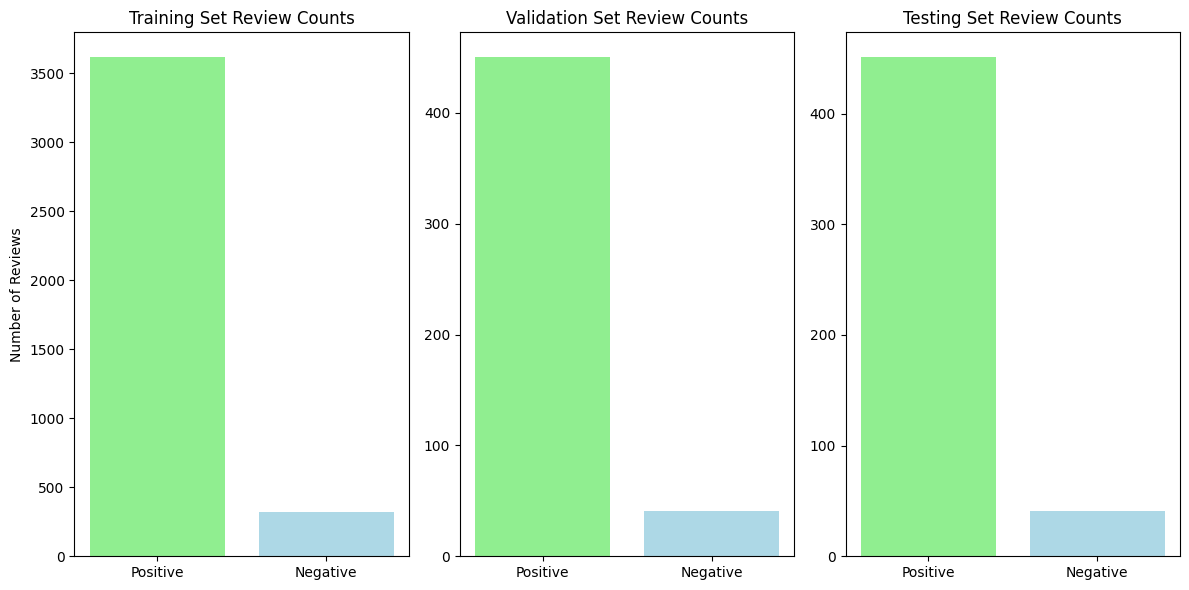

In [147]:
# 4. Plotting the counts of positive and negative reviews
labels = ['Positive', 'Negative']
train_counts = [train_positive_count, train_negative_count]
val_counts = [val_positive_count, val_negative_count]
test_counts = [test_positive_count, test_negative_count]

x = range(len(labels))

plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.bar(x, train_counts, color=['lightgreen', 'lightblue'])
plt.xticks(x, labels)
plt.title('Training Set Review Counts')
plt.ylabel('Number of Reviews')

plt.subplot(1, 3, 2)
plt.bar(x, val_counts, color=['lightgreen', 'lightblue'])
plt.xticks(x, labels)
plt.title('Validation Set Review Counts')

plt.subplot(1, 3, 3)
plt.bar(x, test_counts, color=['lightgreen', 'lightblue'])
plt.xticks(x, labels)
plt.title('Testing Set Review Counts')

plt.tight_layout()
plt.show()

Training Set Class Proportions:
 binary_label
1    91.912513
0     8.087487
Name: proportion, dtype: float64

Validation Set Class Proportions:
 binary_label
1    91.649695
0     8.350305
Name: proportion, dtype: float64

Testing Set Class Proportions:
 binary_label
1    91.666667
0     8.333333
Name: proportion, dtype: float64


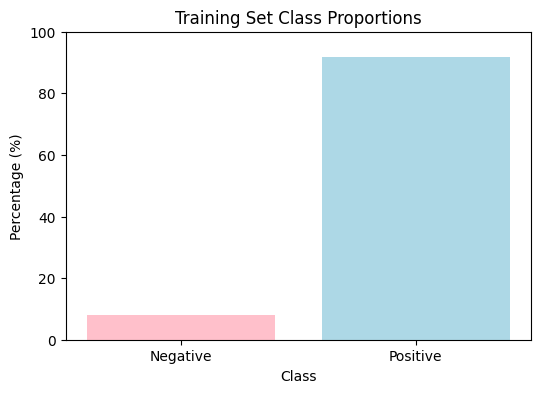

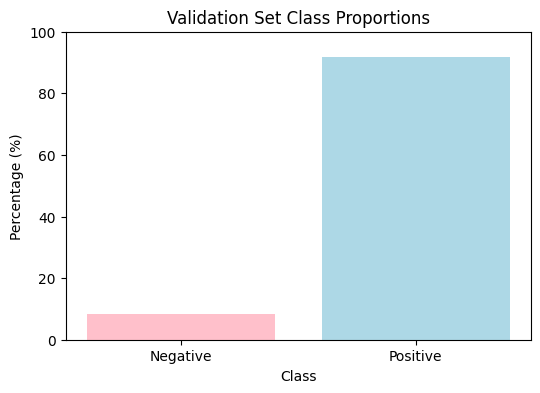

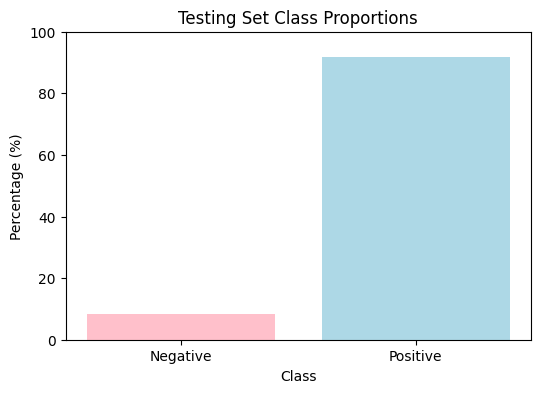

In [148]:
#5. Class Proportion
def class_proportions(df, label_col):
    return df[label_col].value_counts(normalize=True) * 100

train_proportions = class_proportions(train_df, 'binary_label')
val_proportions = class_proportions(val_df, 'binary_label')
test_proportions = class_proportions(test_df, 'binary_label')

print("Training Set Class Proportions:\n", train_proportions)
print("\nValidation Set Class Proportions:\n", val_proportions)
print("\nTesting Set Class Proportions:\n", test_proportions)

def plot_class_proportions(proportions, dataset_name):
    plt.figure(figsize=(6, 4))
    plt.bar(proportions.index, proportions.values, color=['lightblue', 'pink'])
    plt.xticks([0, 1], ['Negative', 'Positive'])
    plt.title(f'{dataset_name} Class Proportions')
    plt.ylabel('Percentage (%)')
    plt.xlabel('Class')
    plt.ylim(0, 100)
    plt.show()

# Plot proportions for each dataset
plot_class_proportions(train_proportions, 'Training Set')
plot_class_proportions(val_proportions, 'Validation Set')
plot_class_proportions(test_proportions, 'Testing Set')

In [149]:
#6.Mean and Median
def class_counts_stats(df, label_col):
    counts = df[label_col].value_counts()
    return counts.mean(), counts.median(), counts

train_mean, train_median, train_counts = class_counts_stats(train_df, 'binary_label')
val_mean, val_median, val_counts = class_counts_stats(val_df, 'binary_label')
test_mean, test_median, test_counts = class_counts_stats(test_df, 'binary_label')

print("Training Set Class Counts:\n", train_counts)
print("Validation Set Class Counts:\n", val_counts)
print("Testing Set Class Counts:\n", test_counts)

print(f"\nTraining Set Mean Count: {train_mean:.2f}, Median Count: {train_median:.2f}")
print(f"\nValidation Set Mean Count: {val_mean:.2f}, Median Count: {val_median:.2f}")
print(f"\nTesting Set Mean Count: {test_mean:.2f}, Median Count: {test_median:.2f}")


Training Set Class Counts:
 binary_label
1    3614
0     318
Name: count, dtype: int64
Validation Set Class Counts:
 binary_label
1    450
0     41
Name: count, dtype: int64
Testing Set Class Counts:
 binary_label
1    451
0     41
Name: count, dtype: int64

Training Set Mean Count: 1966.00, Median Count: 1966.00

Validation Set Mean Count: 245.50, Median Count: 245.50

Testing Set Mean Count: 246.00, Median Count: 246.00


In [150]:
#7.Standard deviation

def class_counts_stats(df, label_col):
    counts = df[label_col].value_counts()
    return counts.mean(), counts.median(), counts.std(), counts

train_mean, train_median, train_std, train_counts = class_counts_stats(train_df, 'binary_label')
val_mean, val_median, val_std, val_counts = class_counts_stats(val_df, 'binary_label')
test_mean, test_median, test_std, test_counts = class_counts_stats(test_df, 'binary_label')

print(f"\nTraining Set Mean Count: {train_mean:.2f}, Median Count: {train_median:.2f}, Standard Deviation: {train_std:.2f}")
print(f"\nValidation Set Mean Count: {val_mean:.2f}, Median Count: {val_median:.2f}, Standard Deviation: {val_std:.2f}")
print(f"\nTesting Set Mean Count: {test_mean:.2f}, Median Count: {test_median:.2f}, Standard Deviation: {test_std:.2f}")



Training Set Mean Count: 1966.00, Median Count: 1966.00, Standard Deviation: 2330.62

Validation Set Mean Count: 245.50, Median Count: 245.50, Standard Deviation: 289.21

Testing Set Mean Count: 246.00, Median Count: 246.00, Standard Deviation: 289.91


In [151]:
# 8.Grouping multi_class_label and calculate token stats
df['tokenLength'] = df['tokenizedReviews'].apply(len)
train_df['tokenLength'] = df['tokenLength'][:len(y_train)].reset_index(drop=True)
token_stats_per_class = train_df.groupby('binary_label')['tokenLength'].agg(['min', 'mean', 'max'])

print("\nToken Statistics Per Class (Training Set):")
print(token_stats_per_class)


Token Statistics Per Class (Training Set):
              min       mean  max
binary_label                     
0               3  23.871069  141
1               0  25.042889  544


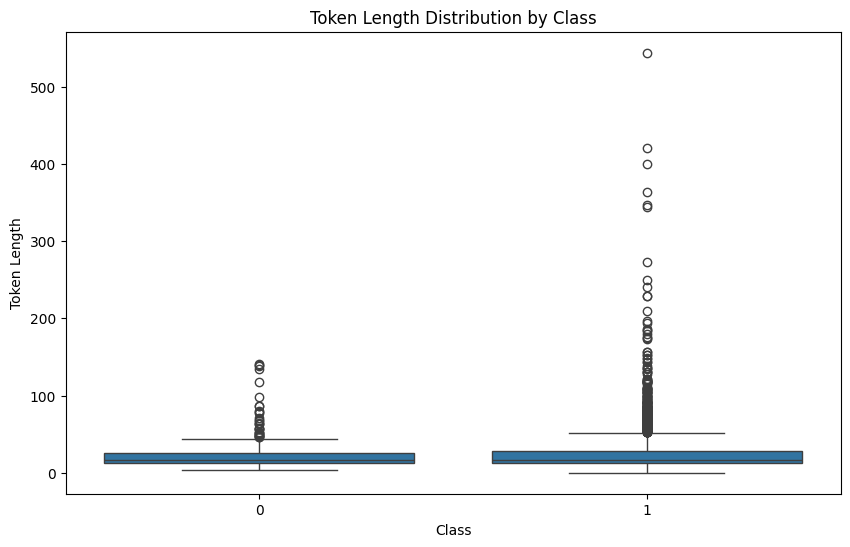

In [152]:
# Visualization of token lengths
plt.figure(figsize=(10, 6))
sns.boxplot(x='binary_label', y='tokenLength', data=train_df)
plt.title('Token Length Distribution by Class')
plt.xlabel('Class')
plt.ylabel('Token Length')
plt.show()

**2. SENTIMENT ANALYSIS WITH RNN**

Following steps explains the implementation of RNN:
1. Tokenization and Padding: The text data is transformed into integer sequences and then padded to have the same length.
2. Tensor Conversion: Converting the padded sequence along with labels into PyTorch tensors for input into the model.
3. LSTM Model Definition: Define an LSTM model that includes embedding, LSTM, and output layers for a binary classification task.
4. Model Configuration: Specify the model configuration, loss, and optimizer to be used.
5. Training Loop: Train the model on several epochs by calculating the losses and accuracy on both training and validation datasets.
6. DataLoading: Create TensorDataset and DataLoader to efficiently batch the data.
7. Train model: This cell will run the training function below and return the final accuracy on the validation and test sets.

In [153]:
# Tokenization and Padding for LSTM
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [154]:
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

maxlen = 100  # Example sequence length
X_train_pad = pad_sequences(X_train_seq, maxlen=maxlen)
X_val_pad = pad_sequences(X_val_seq, maxlen=maxlen)
X_test_pad = pad_sequences(X_test_seq, maxlen=maxlen)

In [155]:
# Convert tokenized data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_pad, dtype=torch.long)
X_val_tensor = torch.tensor(X_val_pad, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_pad, dtype=torch.long)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

In [156]:
#LSTM model
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=2, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        lstm_out = lstm_out[:, -1, :]
        output = self.fc(lstm_out)
        return self.sigmoid(output)

In [157]:
# Parameters
vocab_size = len(tokenizer.word_index) + 1  # Vocabulary size
embedding_dim = 100  # Embedding dimensions
hidden_dim = 64  # LSTM hidden dimensions
output_dim = 1  # Binary classification output

In [158]:
# Create the model instance
model = LSTMModel(vocab_size, embedding_dim, hidden_dim, output_dim)

In [159]:
# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01) #Stochastic gradient descent as optimizer

In [160]:
# Training loop with evaluation on validation and test sets
def train_model(model, train_loader, val_loader, test_loader, optimizer, criterion, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        train_losses = []
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        # Validation
        model.eval()
        val_losses = []
        val_preds = []
        with torch.no_grad():
            for val_inputs, val_labels in val_loader:
                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs.squeeze(), val_labels)
                val_losses.append(val_loss.item())
                val_preds.extend((val_outputs.numpy() > 0.5).astype(np.int32))

        val_accuracy = np.mean(np.array(val_preds) == y_val.values)

        # Test evaluation
        test_losses = []
        test_preds = []
        with torch.no_grad():
            for test_inputs, test_labels in test_loader:
                test_outputs = model(test_inputs)
                test_loss = criterion(test_outputs.squeeze(), test_labels)
                test_losses.append(test_loss.item())
                test_preds.extend((test_outputs.numpy() > 0.5).astype(np.int32))

        test_accuracy = np.mean(np.array(test_preds) == y_test.values)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {np.mean(train_losses):.4f}, Val Loss: {np.mean(val_losses):.4f}, Val Accuracy: {val_accuracy:.4f}, Test Loss: {np.mean(test_losses):.4f}, Test Accuracy: {test_accuracy:.4f}")

    return val_accuracy, test_accuracy

In [161]:
# Create DataLoader instances
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [162]:
# Train the model and get final validation and test accuracies
final_val_accuracy, final_test_accuracy = train_model(model, train_loader, val_loader, test_loader, optimizer, criterion, num_epochs=10)

print(f"Final Validation Accuracy: {final_val_accuracy:.4f}")
print(f"Final Test Accuracy: {final_test_accuracy:.4f}")

Epoch 1/10, Train Loss: 0.6014, Val Loss: 0.5093, Val Accuracy: 0.9165, Test Loss: 0.5119, Test Accuracy: 0.9167
Epoch 2/10, Train Loss: 0.4469, Val Loss: 0.4061, Val Accuracy: 0.9165, Test Loss: 0.4113, Test Accuracy: 0.9167
Epoch 3/10, Train Loss: 0.3691, Val Loss: 0.3532, Val Accuracy: 0.9165, Test Loss: 0.3604, Test Accuracy: 0.9167
Epoch 4/10, Train Loss: 0.3279, Val Loss: 0.3252, Val Accuracy: 0.9165, Test Loss: 0.3341, Test Accuracy: 0.9167
Epoch 5/10, Train Loss: 0.3060, Val Loss: 0.3108, Val Accuracy: 0.9165, Test Loss: 0.3210, Test Accuracy: 0.9167
Epoch 6/10, Train Loss: 0.2944, Val Loss: 0.3033, Val Accuracy: 0.9165, Test Loss: 0.3145, Test Accuracy: 0.9167
Epoch 7/10, Train Loss: 0.2878, Val Loss: 0.2994, Val Accuracy: 0.9165, Test Loss: 0.3114, Test Accuracy: 0.9167
Epoch 8/10, Train Loss: 0.2842, Val Loss: 0.2975, Val Accuracy: 0.9165, Test Loss: 0.3100, Test Accuracy: 0.9167
Epoch 9/10, Train Loss: 0.2825, Val Loss: 0.2965, Val Accuracy: 0.9165, Test Loss: 0.3095, Test 

**3. SENTIMENT ANALYSIS WITH CNN**

Following steps explains the implementation of CNN:
1. GloVe Embeddings: This loads the pre-trained GloVe embeddings into an embedding matrix meant for the representation of words.
2. Tensor Conversion: Here, padded sequences and labels are converted to PyTorch tensors.
3. CNN Model Definition: This defines a three-layer convolutional neural network that performs sentiment classification.
4. Model Training: This is a training of the CNN model in a loop for a number of epochs by using the Adam optimizer and binary cross-entropy loss.
5. Model Evaluation: The performance of the model is evaluated by comparing the predictions with the true labels on the validation dataset and then on the test dataset.

In [163]:
texts = df['cleanedReviews'].values
labels = df['binary_label'].values

In [164]:
# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index

In [165]:
# Padding sequences
max_length = max(len(x) for x in sequences)
X = pad_sequences(sequences, maxlen=max_length)
y = labels

In [166]:
# Split the data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [167]:
# Load GloVe embeddings
def load_glove_embeddings(glove_file):
    embeddings_index = {}
    with open(glove_file, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index


In [168]:
#Load GloVe word embeddings
glove_embeddings = load_glove_embeddings('glove.6B.100d.txt')

In [169]:
# Create an embedding matrix
embedding_dim = 100
num_words = min(20000, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in word_index.items():
    if i < num_words:
        embedding_vector = glove_embeddings.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [170]:
# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.long)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [171]:
# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)

In [172]:
# Define the CNN model
class SentimentCNN(nn.Module):
    def __init__(self, embedding_matrix):
        super(SentimentCNN, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix), freeze=False)
        self.conv1 = nn.Conv2d(1, 100, (3, embedding_matrix.shape[1]))
        self.conv2 = nn.Conv2d(1, 100, (4, embedding_matrix.shape[1]))
        self.conv3 = nn.Conv2d(1, 100, (5, embedding_matrix.shape[1]))
        self.fc = nn.Linear(300, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        x = x.unsqueeze(1)
        conv1_out = self.conv1(x)
        conv1_out = nn.functional.relu(conv1_out.squeeze(3))
        conv1_out = nn.functional.max_pool1d(conv1_out, conv1_out.size(2)).squeeze(2)

        conv2_out = self.conv2(x)
        conv2_out = nn.functional.relu(conv2_out.squeeze(3))
        conv2_out = nn.functional.max_pool1d(conv2_out, conv2_out.size(2)).squeeze(2)

        conv3_out = self.conv3(x)
        conv3_out = nn.functional.relu(conv3_out.squeeze(3))
        conv3_out = nn.functional.max_pool1d(conv3_out, conv3_out.size(2)).squeeze(2)

        x = torch.cat((conv1_out, conv2_out, conv3_out), 1)
        x = self.fc(x)
        x = self.sigmoid(x)
        return x

In [173]:
# Initialize the model, optimizer, and loss function
model = SentimentCNN(embedding_matrix)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

In [174]:
# Train the model
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}')

In [175]:
#Train model using Training dataset
train_model(model, train_loader, criterion, optimizer)

Epoch 1/10, Loss: 0.2293
Epoch 2/10, Loss: 0.1215
Epoch 3/10, Loss: 0.0572
Epoch 4/10, Loss: 0.0208
Epoch 5/10, Loss: 0.0085
Epoch 6/10, Loss: 0.0035
Epoch 7/10, Loss: 0.0017
Epoch 8/10, Loss: 0.0011
Epoch 9/10, Loss: 0.0008
Epoch 10/10, Loss: 0.0006


In [176]:
# Evaluate the model
def evaluate_model(model, X_val_tensor, y_val_tensor):
    model.eval()
    with torch.no_grad():
        outputs = model(X_val_tensor).squeeze()
        predictions = (outputs >= 0.5).float()
        accuracy = (predictions == y_val_tensor).float().mean().item()
    return accuracy

val_accuracy = evaluate_model(model, X_val_tensor, y_val_tensor)
print(f'Validation Accuracy: {val_accuracy:.4f}')

Validation Accuracy: 0.9613


In [177]:
# Test the model
test_accuracy = evaluate_model(model, X_test_tensor, y_test_tensor)
print(f'Test Accuracy: {test_accuracy:.4f}')

Test Accuracy: 0.9451


**4.EVALUATION**

4.1. Evaluating the model performances

In [178]:
# Function to evaluate the RNN model
def evaluate_model_rnn(model, data_loader, y_true):
    model.eval()
    preds = []
    with torch.no_grad():
        for inputs, labels in data_loader:
            outputs = model(inputs)
            preds.extend((outputs.numpy() > 0.5).astype(np.int32))

    preds = np.array(preds).flatten()

    # Calculate metrics
    accuracy = accuracy_score(y_true, preds)
    precision = precision_score(y_true, preds)
    recall = recall_score(y_true, preds)
    f1 = f1_score(y_true, preds)
    auc = roc_auc_score(y_true, preds)

    return accuracy, precision, recall, f1, auc

y_val_true = y_val_tensor.numpy()
y_test_true = y_test_tensor.numpy()

# Evaluate on the validation set (RNN)
val_accuracy_rnn, val_precision_rnn, val_recall_rnn, val_f1_rnn, val_auc_rnn = evaluate_model_rnn(model, val_loader, y_val_true)
print(f"RNN Validation Set Metrics:")
print(f"Accuracy: {val_accuracy_rnn:.4f}, Precision: {val_precision_rnn:.4f}, Recall: {val_recall_rnn:.4f}, F1-Score: {val_f1_rnn:.4f}, AUC: {val_auc_rnn:.4f}")

# Evaluate on the test set (RNN)
test_accuracy_rnn, test_precision_rnn, test_recall_rnn, test_f1_rnn, test_auc_rnn = evaluate_model_rnn(model, test_loader, y_test_true)
print(f"RNN Test Set Metrics:")
print(f"Accuracy: {test_accuracy_rnn:.4f}, Precision: {test_precision_rnn:.4f}, Recall: {test_recall_rnn:.4f}, F1-Score: {test_f1_rnn:.4f}, AUC: {test_auc_rnn:.4f}")


RNN Validation Set Metrics:
Accuracy: 0.9104, Precision: 0.9160, Recall: 0.9933, F1-Score: 0.9531, AUC: 0.4967
RNN Test Set Metrics:
Accuracy: 0.9126, Precision: 0.9163, Recall: 0.9956, F1-Score: 0.9543, AUC: 0.4978


In [179]:
# Function to evaluate the CNN model
def evaluate_cnn(model, X_tensor, y_tensor):
    model.eval()
    with torch.no_grad():
        outputs = model(X_tensor).squeeze()
        predictions = (outputs >= 0.5).float()
        pred_numpy = predictions.cpu().numpy()
        y_numpy = y_tensor.cpu().numpy()

        # Compute the metrics
        accuracy = accuracy_score(y_numpy, pred_numpy)
        precision = precision_score(y_numpy, pred_numpy)
        recall = recall_score(y_numpy, pred_numpy)
        f1 = f1_score(y_numpy, pred_numpy)
        auc = roc_auc_score(y_numpy, outputs.cpu().numpy())

        print(f'Accuracy: {accuracy:.4f}')
        print(f'Precision: {precision:.4f}')
        print(f'Recall: {recall:.4f}')
        print(f'F1-Score: {f1:.4f}')
        print(f'AUC: {auc:.4f}')

        return accuracy, precision, recall, f1, auc

# Evaluate on validation set
print("Validation Set Performance:")
evaluate_cnn(model, X_val_tensor, y_val_tensor)

# Evaluate on test set
print("Test Set Performance:")
evaluate_cnn(model, X_test_tensor, y_test_tensor)


Validation Set Performance:
Accuracy: 0.9613
Precision: 0.9675
Recall: 0.9911
F1-Score: 0.9791
AUC: 0.9714
Test Set Performance:
Accuracy: 0.9451
Precision: 0.9511
Recall: 0.9911
F1-Score: 0.9707
AUC: 0.9594


(0.9451219512195121,
 0.951063829787234,
 0.991130820399113,
 0.9706840390879479,
 0.9593856470715483)

4.2. Discussions:
1. Accuracy: The performance of CNN is higher than RNN for both validation and test accuracy, CNN: 0.9613, 0.9451 vs RNN: 0.9104, 0.9126. This means that CNN gives better performance in correctly classifying the sentiments of reviews.
2. Precision: CNN exhibits better precision values, too (CNN: 0.9675, 0.9511 vs RNN: 0.9160, 0.9163) which in turn proves that when the CNN model predicts a positive sentiment, it tends to be correct. Hence, there are few false positives when compared to RNN.
3. Recall: Both models have high recall, which means they are able to identify most of the actual positive sentiments. The RNN has an advantage in recall over the CNN in both sets: RNN has 0.9933 and 0.9956, while CNN has 0.9911 and 0.9911. This  means that RNN was better at catching positive reviews but at the expense of lower precision.
4. F1-score: the F1-score, which balances precision and recall, is higher for the CNN. That means that generally, the CNN performed better. The CNN model shows more consistency in its ability to classify sentiment while trying to minimize both false positives and false negatives.
5. AUC score: It can be seen that the AUC for the CNN model is far greater as compared to the AUC from the RNN model. CNN: 0.9714, 0.9594; RNN: 0.4967, 0.4978. That means CNN is far superior in distinguishing between positive and negative classes when compared to the RNN model.

In summary, the CNN model performs significantly better than the RNN model in each significant information, particularly in accuracy, precision, F1-score, and AUC. Although the RNN's recall is impressive, it seems to perform worse than the CNN in terms of accuracy and overall classification. The results obtained suggest that the CNN is a more efficient model for the given sentiment analysis task because of its better ability to learn relevant features and provide balanced classifying measures.


4.3. Discussions on HW1 and HW2 Results

***A. Differences between the HW1 and HW2***
1. Classification type:
HW1: The task was a multiclass classification problem using logistic regression and a neural network, where the goal was to discriminate between more than two classes.
HW2: Hence the problem was a binary classification problem; it was simplified to a two-class problem.
2. Overall performance improvements: The measures of performance in HW2, namely accuracy, precision, recall, and F1-score, were much better compared to HW1. Generally speaking, the models developed in HW2 have higher generalization capability: an RNN and a CNN.
3. Metrics Evaluation:
* Logistic Regression HW1: This has an accuracy of 0.776. However, it struggled a lot in class differentiation for major classes 1 through 4.
* Neural Network HW1: which has a validation accuracy of 0.784 and a test accuracy of 0.807. Again, both faced major challenges in classes 1 through 4.
* RNN HW2: 0.9104 validation accuracy and 0.9126 test accuracy; also, very high precision and recall. It means very good performance for a binary classifier.
* CNN HW2: The best result came to be 0.9613 validation accuracy and 0.9451 test accuracy. This CNN worked quite well on this dataset, giving good metrics both on the validation and test set.

***B. Best Model Performance:***
CNN is the best-performing model with:

* Validation Accuracy: 0.9613
* Test Accuracy: 0.9451
* F1-Score: 0.9707

***C. Discussion of Findings:***

1. Classification Complexity: Intrinsic to multiclass classification in HW1 is the shift to binary classification in HW2. This simplifies the problem and inherently allows models to more easily achieve higher accuracy and lower error rates. Binary classification generally requires the discrimination of two classes, usually focusing on fewer nuances.
2. Model Architecture: In contrast, HW2's more complicated models—such as CNN and RNN—are more suited to capturing the complexity of the data than HW1's more straightforward design. They learnt more complex patterns, which explains their performances.
3. Data Representation: In HW2, the models' performance was probably enhanced by the addition of embeddings for input representations, which helped them to more accurately understand dependent connections. In comparison, the representation may not have been as successful for multiclass classification in HW1.
4. Generalization: The RNN and CNN models in HW2 showed better generalization because of how well they can effectively handle the classification problem's binary character. Their strong accuracy and recall measures make this particularly evident.
5. Class Imbalance Handling: Compared to multiclass settings, binary classification has a lower chance of class imbalance, which might make model training and evaluation challenging.   This simpler class structure probably helped the models in HW2.


***D. Conclusion:***
In summary, the comparison of HW1 and HW2 shows that shifting from basic methods to deep learning models significantly enhances model performance. HW1's logistic regression and neural network models performed rather well, but they had trouble differentiating between classes, especially when there were multiple ones.   On the other hand, the CNN and RNN models used in HW2 demonstrated considerable improvements, achieving better recall, accuracy, and precision in their corresponding tasks. In particular, the CNN performed better than any of the other models, showing its ability to detect complicated connection and patterns in the data. This change shows how important it is to choose the right model designs depending on the kind of classification problem, showing how advanced methods may improve overall performance and prediction capabilities.




**5. SELF-REFLECTION:**

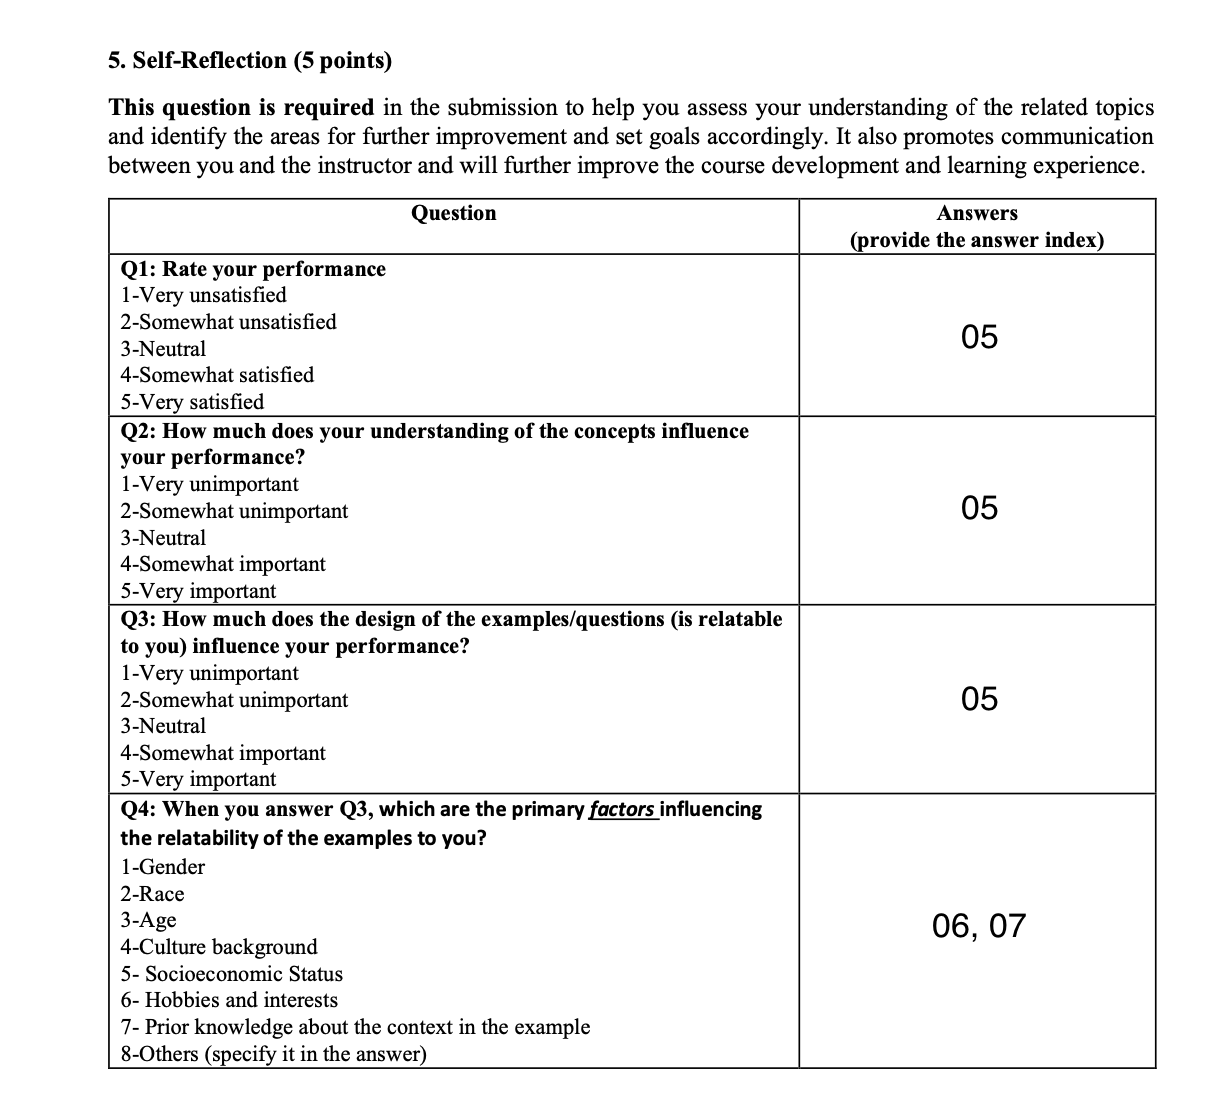

*Reference:*

[1]Hochreiter, S., & Schmidhuber, J. (1997). Long short-term memory. Neural Computation, 9(8), 1735-1780.

[2]LeCun, Y., Bottou, L., Bengio, Y., & Haffner, P. (1998). Convolutional networks for images, speech, and time-series. Proceedings of the IEEE, 86(11), 2278-2324.

[3] Pennington, J., Socher, R., & Manning, C. D. (2014). GloVe: Global Vectors for Word Representation. Stanford University. https://nlp.stanford.edu/projects/glove/

[4] Ng, A. (2021). Machine learning [Online course]. Coursera. https://www.coursera.org/learn/machine-learning